# RSI STRATEGY

The RSI is a widely used technical indicator and an oscillator that indicates a market is overbought when the RSI value is over 70 and indicates oversold conditions when RSI readings are under 30. Some traders and analysts prefer to use the more extreme readings of 80 and 20. A weakness of the RSI is that sudden, sharp price movements can cause it to spike repeatedly up or down, and, thus, it is prone to giving false signals.

In [1]:
%matplotlib inline  

import pandas as pd
import talib as tl
import numpy as np

In [2]:
def load(file):
    df = pd.read_csv(file, skiprows=1)
    return df.reindex(index=df.index[::-1]).reset_index()

In [3]:
datasets = {
    "BTCUSD": load('data/Bitstamp_BTCUSD_1h.csv'),
    "ETHUSD": load('data/Bitstamp_ETHUSD_1h.csv'),
    "LTCUSD": load('data/Bitstamp_LTCUSD_1h.csv'),
    "XRPUSD": load('data/Bitstamp_XRPUSD_1h.csv'),
    "ETHBTC": load('data/Binance_ETHBTC_1h.csv'),
    "LTCBTC": load('data/Binance_LTCBTC_1h.csv'),
    "XMRBTC": load('data/Binance_XMRBTC_1h.csv')
}

In [4]:
def benchRSI(df, lowRSI = 30.0, highRSI = 70.):
    data = df.copy()
    data['RSI'] = tl.RSI(data.Close, timeperiod = 14)
    data = data[(data.RSI < 30.) | (data.RSI > 70.)]

    def advice(rsi):
        if rsi<30:
            #buy
            return 'long'
        if rsi>70:
            #sell
            return 'short'
        return np.nan

    data['advice'] = data['RSI'].apply(advice)
    data['prevAdvice'] = data['advice'].shift()
    data = data[data.prevAdvice != data.advice][['Date', 'Close', 'RSI', 'advice']]

    data['enterprice'] = data.Close.shift()

    if data.advice.values[0] == 'short':
        data = data[1:]

    data = data.dropna()
    deals = data[data.advice == 'short'].copy()
    deals['earn'] = (deals.Close - deals.enterprice) / deals.enterprice
    data.drop(['enterprice'], axis=1)
    
    return deals.earn, data

In [40]:
def computePositions(data):
    rows = []
    positionTake = False
    for i, e in data.iterrows():

        if e.advice == 'short' and positionTake:
            # close position
            rows.append({
                "enter": position.Date,
                "exit": e.Date,
                "buyprice": position.Close,
                "sellprice": e.Close,
                "profit": (e.Close - position.Close) / position.Close,
            })
        else:
            # open position
            positionTake = True
            position = e
    return pd.DataFrame(rows)

In [42]:
results = {}
for e in datasets:
    roi, log = benchRSI(datasets[e])
    results[e] = { "roi": roi, "roiAvg": roi.mean(), "log": log, "positions": computePositions(log) }
    

In [43]:
for e in results:
    print(e)
    print('ntrades', len(results[e]['roi']), ', mean roi',results[e]['roiAvg'])

BTCUSD
ntrades 51 , mean roi 0.0026732290726156184
ETHUSD
ntrades 41 , mean roi -0.035216098055810066
LTCUSD
ntrades 52 , mean roi 0.009105792318809352
XRPUSD
ntrades 50 , mean roi -0.012605270973493005
ETHBTC
ntrades 57 , mean roi -0.02249376560882072
LTCBTC
ntrades 53 , mean roi -0.006085037037699648
XMRBTC
ntrades 39 , mean roi 0.025003177837482283


In [47]:
results["ETHBTC"]["positions"]

,buyprice,enter,exit,profit,sellprice
0,0.08592,2017-07-16 01-AM,2017-07-18 02-PM,0.097416,0.09429
1,0.07937,2017-07-20 10-PM,2017-07-29 10-PM,-0.072068,0.07365
2,0.07613,2017-08-05 01-AM,2017-08-08 02-PM,0.121240,0.08536
3,0.08016,2017-08-12 11-PM,2017-08-21 04-AM,-0.072231,0.07437
4,0.07830,2017-09-02 01-AM,2017-09-18 01-AM,-0.086590,0.07152
5,0.07086,2017-09-21 07-PM,2017-09-23 07-AM,0.050522,0.07444
6,0.07436,2017-09-26 07-AM,2017-10-06 06-PM,-0.060651,0.06985
7,0.06850,2017-10-08 01-PM,2017-10-24 01-AM,-0.217518,0.05360
8,0.05024,2017-10-26 12-PM,2017-10-29 11-AM,0.050756,0.05279
9,0.04855,2017-10-31 01-PM,2017-11-06 03-PM,-0.134912,0.04200


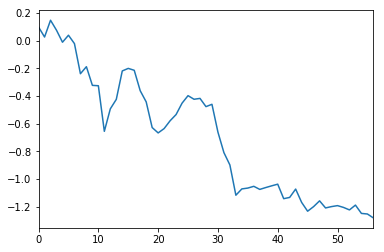

In [50]:
results["ETHBTC"]["positions"].profit.cumsum().plot()